# microWakeWord Training On Custom Audios

This notebook covers training [microWakeWord](https://github.com/kahrendt/microWakeWord/tree/main) on recorded audios.
These Audios should be saved in the `generated_samples` folder.

The trained `.tflite` is present in `trained_models/wakeword/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite`

This notebook was modified from `https://github.com/kahrendt/microWakeWord/blob/main/notebooks/basic_training_notebook.ipynb`

# Setup Environment

In [15]:
!python3 -m venv .venv
!source .venv/bin/activate.fish


# Installs microWakeWord. Be sure to restart the session after this is finished.
import platform

if platform.system() == "Darwin":
    # `pymicro-features` is installed from a fork to support building on macOS
    !pip install 'git+https://github.com/puddly/pymicro-features@puddly/minimum-cpp-version'

# `audio-metadata` is installed from a fork to unpin `attrs` from a version that breaks Jupyter
%pip install 'git+https://github.com/whatsnowplaying/audio-metadata@d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f'

!git clone https://github.com/kahrendt/microWakeWord
%pip install -e ./microWakeWord

%pip install matplotlib seaborn torch torchaudio piper-phonemize-cross==1.2.1 torchcodec

# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install webrtcvad piper-phonemize torch torchaudio datasets scipy torchcodec

  Cloning https://github.com/whatsnowplaying/audio-metadata (to revision d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f) to /tmp/pip-req-build-bbhaknzn
  Running command git clone --filter=blob:none --quiet https://github.com/whatsnowplaying/audio-metadata /tmp/pip-req-build-bbhaknzn
  Running command git rev-parse -q --verify 'sha^d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f'
  Running command git fetch -q https://github.com/whatsnowplaying/audio-metadata d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f
  Running command git checkout -q d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f
  Resolved https://github.com/whatsnowplaying/audio-metadata to commit d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'microWakeWord' already exists and is not an empty directory.
Obtaining file:///mnt/projects/mic

# Training a microWakeWord Model

This notebook steps you through training a basic microWakeWord model. It is intended as a **starting point** for advanced users. You should use Python 3.10.

**The model generated will most likely not be usable for everyday use; it may be difficult to trigger or falsely activates too frequently. You will most likely have to experiment with many different settings to obtain a decent model!**

In the comment at the start of certain blocks, I note some specific settings to consider modifying.

This runs on Google Colab, but is extremely slow compared to training on a local GPU. If you must use Colab, be sure to Change the runtime type to a GPU. Even then, it still slow!

At the end of this notebook, you will be able to download a tflite file. To use this in ESPHome, you need to write a model manifest JSON file. See the [ESPHome documentation](https://esphome.io/components/micro_wake_word) for the details and the [model repo](https://github.com/esphome/micro-wake-word-models/tree/main/models/v2) for examples.

In [ ]:
# Installs microWakeWord. Be sure to restart the session after this is finished.
import platform

if platform.system() == "Darwin":
    # `pymicro-features` is installed from a fork to support building on macOS
    %pip install 'git+https://github.com/puddly/pymicro-features@puddly/minimum-cpp-version'

# `audio-metadata` is installed from a fork to unpin `attrs` from a version that breaks Jupyter
%pip install 'git+https://github.com/whatsnowplaying/audio-metadata@d4ebb238e6a401bb1a5aaaac60c9e2b3cb30929f'

!git clone https://github.com/kahrendt/microWakeWord
%pip install -e ./microWakeWord

# Generate More Training Data

Generates 1000 more words for the given wake word

In [ ]:
# Determines the target phrase for the wake word model.
target_phrase = 'hay_jar‑viss' # Phonetic spellings may produce better samples

# Generates samples for the target phrase.
!python3 piper-sample-generator/generate_samples.py "{target_phrase}" \
--max-samples 1000 \
--batch-size 100 \
--output-dir generated_samples

In [ ]:
# Now, copy all audi files from `recorded_samples` to `generated_samples`

!cp -r ./recorded_samples/* ./generated_samples/

# Augment Data

In [ ]:
# Downloads audio data for augmentation. This can be slow!
# Borrowed from openWakeWord's automatic_model_training.ipynb, accessed March 4, 2024
#
# **Important note!** The data downloaded here has a mixture of difference
# licenses and usage restrictions. As such, any custom models trained with this
# data should be considered as appropriate for **non-commercial** personal use only.


import datasets
import scipy
import os

import numpy as np

from pathlib import Path
from tqdm import tqdm

## Download MIR RIR data

output_dir = "./mit_rirs"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    rir_dataset = datasets.load_dataset("davidscripka/MIT_environmental_impulse_responses", split="train", streaming=True)
    # Save clips to 16-bit PCM wav files
    for row in tqdm(rir_dataset):
        name = row['audio']['path'].split('/')[-1]
        scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))

## Download noise and background audio

# Audioset Dataset (https://research.google.com/audioset/dataset/index.html)
# Download one part of the audioset .tar files, extract, and convert to 16khz
# For full-scale training, it's recommended to download the entire dataset from
# https://huggingface.co/datasets/agkphysics/AudioSet, and
# even potentially combine it with other background noise datasets (e.g., FSD50k, Freesound, etc.)

if not os.path.exists("audioset"):
    os.mkdir("audioset")

    fname = "bal_train09.tar"
    out_dir = f"audioset/{fname}"
    link = "https://huggingface.co/datasets/agkphysics/AudioSet/resolve/main/data/" + fname
    !wget -O {out_dir} {link}
    !cd audioset && tar -xf bal_train09.tar

    output_dir = "./audioset_16k"
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    # Save clips to 16-bit PCM wav files
    audioset_dataset = datasets.Dataset.from_dict({"audio": [str(i) for i in Path("audioset/audio").glob("**/*.flac")]})
    audioset_dataset = audioset_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
    for row in tqdm(audioset_dataset):
        name = row['audio']['path'].split('/')[-1].replace(".flac", ".wav")
        scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))

# Free Music Archive dataset
# https://github.com/mdeff/fma
# (Third-party mchl914 extra small set)

output_dir = "./fma"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    fname = "fma_xs.zip"
    link = "https://huggingface.co/datasets/mchl914/fma_xsmall/resolve/main/" + fname
    out_dir = f"fma/{fname}"
    !wget -O {out_dir} {link}
    !cd {output_dir} && unzip -q {fname}

    output_dir = "./fma_16k"
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    # Save clips to 16-bit PCM wav files
    fma_dataset = datasets.Dataset.from_dict({"audio": [str(i) for i in Path("fma/fma_small").glob("**/*.mp3")]})
    fma_dataset = fma_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
    for row in tqdm(fma_dataset):
        name = row['audio']['path'].split('/')[-1].replace(".mp3", ".wav")
        scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))


## Audio Augmentation Setup

This section configures the audio augmentation pipeline for training:
- **PatchedClips**: Uses a custom implementation that loads audio with torchaudio to avoid compatibility issues
- **Augmentation**: Applies various effects (EQ, distortion, pitch shift, noise, etc.) to increase data diversity  
- **Background Sources**: Uses impulse responses (`mit_rirs`) and background datasets (`fma_16k`, `audioset_16k`)

**Important:** Run the PatchedClips cell before the augmentation cell to avoid the "0 channels" error with torchcodec.

In [ ]:
# Sets up the augmentations.
# To improve your model, experiment with these settings and use more sources of
# background clips.

from microwakeword.audio.augmentation import Augmentation
from microwakeword.audio.spectrograms import SpectrogramGeneration

# The clips object should already be initialized by the PatchedClips cell below
# If you get errors, run the PatchedClips cell first to avoid torchcodec issues

# Fix for "RuntimeError: The frame has 0 channels, expected 1" error
# This creates a patched version of Clips that uses torchaudio directly instead of torchcodec

import os
import random
import numpy as np
import torchaudio
import torch
from pathlib import Path
from microwakeword.audio.clips import Clips

class MockDatasetItem:
    """Mock dataset item that mimics the behavior of datasets library items."""
    def __init__(self, audio_data, sample_rate=16000):
        self.audio_data = audio_data
        self.sample_rate = sample_rate
    
    def __getitem__(self, key):
        if key == "audio":
            return {
                "array": self.audio_data,
                "sampling_rate": self.sample_rate
            }
        return None

class MockDataset:
    """Mock dataset that mimics the behavior of datasets.Dataset."""
    def __init__(self, clips_list):
        self.clips_list = clips_list
    
    def __iter__(self):
        for clip in self.clips_list:
            yield MockDatasetItem(clip['audio_data'], clip['sample_rate'])
    
    def __getitem__(self, idx):
        clip = self.clips_list[idx]
        return MockDatasetItem(clip['audio_data'], clip['sample_rate'])
    
    def __len__(self):
        return len(self.clips_list)

class PatchedClips(Clips):
    """
    Patched version of Clips that uses torchaudio directly to avoid torchcodec compatibility issues.
    """
    
    def __init__(self, input_directory, file_pattern='*.wav', **kwargs):
        # Don't call super().__init__ to avoid the datasets setup
        self.input_directory = input_directory
        self.file_pattern = file_pattern
        self.max_clip_duration_s = kwargs.get('max_clip_duration_s', None)
        self.remove_silence = kwargs.get('remove_silence', False)
        self.random_split_seed = kwargs.get('random_split_seed', 10)
        self.split_count = kwargs.get('split_count', 0.1)
        
        # Initialize attributes needed by parent class methods
        self.min_clip_duration_s = 0.0
        self.repeat_clip_min_duration_s = 0.0
        self.trimmed_clip_duration_s = kwargs.get('trimmed_clip_duration_s', None)
        self.trim_zeros = kwargs.get('trim_zeros', False)
        
        if self.remove_silence:
            from microwakeword.audio.audio_utils import remove_silence_webrtc
            self.remove_silence_function = remove_silence_webrtc
        
        self._load_clips_custom()
        self._setup_splits()
    
    def _load_clips_custom(self):
        """Load clips using torchaudio directly."""
        input_path = Path(self.input_directory)
        audio_files = list(input_path.glob(self.file_pattern))
        
        print(f"Loading {len(audio_files)} audio files with torchaudio...")
        
        self.clips_data = []
        for i, audio_file in enumerate(sorted(audio_files)):
            try:
                waveform, sample_rate = torchaudio.load(str(audio_file))
                if waveform.shape[0] > 1:  # Convert to mono
                    waveform = torch.mean(waveform, dim=0, keepdim=True)
                
                audio_array = waveform.squeeze().numpy()
                
                clip_entry = {
                    'path': str(audio_file),
                    'audio_data': audio_array,
                    'sample_rate': sample_rate,
                    'duration': len(audio_array) / sample_rate
                }
                
                if self.max_clip_duration_s is None or clip_entry['duration'] <= self.max_clip_duration_s:
                    self.clips_data.append(clip_entry)
                    
            except Exception as e:
                print(f"Error loading {audio_file}: {e}")
                continue
        
        print(f"Successfully loaded {len(self.clips_data)} valid audio clips")
        
        # Create the clips dataset (needed for get_random_clip compatibility)
        self.clips = MockDataset(self.clips_data)
    
    def _setup_splits(self):
        """Set up train/validation splits."""
        if self.split_count > 0 and self.random_split_seed is not None:
            random.seed(self.random_split_seed)
            
            # Shuffle and split
            clips_copy = self.clips_data.copy()
            random.shuffle(clips_copy)
            
            split_idx = int(len(clips_copy) * self.split_count)
            self.validation_clips_data = clips_copy[:split_idx]
            self.train_clips_data = clips_copy[split_idx:]
            
            # Create mock dataset dict for compatibility with SpectrogramGeneration
            self.split_clips = {
                'train': MockDataset(self.train_clips_data),
                'validation': MockDataset(self.validation_clips_data),
                'test': MockDataset(self.validation_clips_data)  # Use validation as test for now
            }
        else:
            self.train_clips_data = self.clips_data
            self.validation_clips_data = []
            
            # Create mock dataset dict
            self.split_clips = {
                'train': MockDataset(self.train_clips_data),
                'validation': MockDataset([]),
                'test': MockDataset([])
            }
    
    def get_random_clip(self, max_retries=5):
        """Get a random audio clip."""
        return random.choice(self.clips_data)['audio_data']
    
    def get_clip(self, split='train'):
        """Get clips for a specific split."""
        if split == 'train':
            return random.choice(self.train_clips_data)['audio_data']
        elif split == 'validation':
            return random.choice(self.validation_clips_data)['audio_data'] if self.validation_clips_data else self.get_random_clip()
        else:
            return self.get_random_clip()

# Initialize the patched clips class
clips = PatchedClips(
    input_directory='generated_samples',
    file_pattern='*.wav',
    max_clip_duration_s=None,
    remove_silence=False,
    random_split_seed=10,
    split_count=0.1,
)

print(f"✅ PatchedClips initialized: {len(clips.clips_data)} total clips")
if hasattr(clips, 'train_clips_data'):
    print(f"   Train clips: {len(clips.train_clips_data)}, Validation clips: {len(clips.validation_clips_data)}")

# Now initialize the augmenter
augmenter = Augmentation(augmentation_duration_s=3.2,
                         augmentation_probabilities = {
                                "SevenBandParametricEQ": 0.1,
                                "TanhDistortion": 0.1,
                                "PitchShift": 0.1,
                                "BandStopFilter": 0.1,
                                "AddColorNoise": 0.1,
                                "AddBackgroundNoise": 0.75,
                                "Gain": 1.0,
                                "RIR": 0.5,
                            },
                         impulse_paths = ['mit_rirs'],
                         background_paths = ['fma_16k', 'audioset_16k'],
                         background_min_snr_db = -5,
                         background_max_snr_db = 10,
                         min_jitter_s = 0.195,
                         max_jitter_s = 0.205,
                         )

# Test the augmentation pipeline
from IPython.display import Audio
from microwakeword.audio.audio_utils import save_clip

print("Testing augmentation pipeline...")
random_clip = clips.get_random_clip()
augmented_clip = augmenter.augment_clip(random_clip)
save_clip(augmented_clip, 'augmented_clip.wav')
print("✅ Augmentation test successful!")

Audio("augmented_clip.wav", autoplay=True)

In [ ]:
# Augment samples and save the training, validation, and testing sets.
# Validating and testing samples generated the same way can make the model
# benchmark better than it performs in real-word use. Use real samples or TTS
# samples generated with a different TTS engine to potentially get more accurate
# benchmarks.

import os
from mmap_ninja.ragged import RaggedMmap

output_dir = 'generated_augmented_features'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

splits = ["training", "validation", "testing"]
for split in splits:
  out_dir = os.path.join(output_dir, split)
  if not os.path.exists(out_dir):
      os.mkdir(out_dir)


  split_name = "train"
  repetition = 2

  spectrograms = SpectrogramGeneration(clips=clips,
                                     augmenter=augmenter,
                                     slide_frames=10,    # Uses the same spectrogram repeatedly, just shifted over by one frame. This simulates the streaming inferences while training/validating in nonstreaming mode.
                                     step_ms=10,
                                     )
  if split == "validation":
    split_name = "validation"
    repetition = 1
  elif split == "testing":
    split_name = "test"
    repetition = 1
    spectrograms = SpectrogramGeneration(clips=clips,
                                     augmenter=augmenter,
                                     slide_frames=1,    # The testing set uses the streaming version of the model, so no artificial repetition is necessary
                                     step_ms=10,
                                     )

  RaggedMmap.from_generator(
      out_dir=os.path.join(out_dir, 'wakeword_mmap'),
      sample_generator=spectrograms.spectrogram_generator(split=split_name, repeat=repetition),
      batch_size=100,
      verbose=True,
  )

In [ ]:
# Downloads pre-generated spectrogram features (made for microWakeWord in
# particular) for various negative datasets. This can be slow!

output_dir = './negative_datasets'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    link_root = "https://huggingface.co/datasets/kahrendt/microwakeword/resolve/main/"
    filenames = ['dinner_party.zip', 'dinner_party_eval.zip', 'no_speech.zip', 'speech.zip']
    for fname in filenames:
        link = link_root + fname

        zip_path = f"negative_datasets/{fname}"
        !wget -O {zip_path} {link}
        !unzip -q {zip_path} -d {output_dir}

In [ ]:
# Save a yaml config that controls the training process
# These hyperparamters can make a huge different in model quality.
# Experiment with sampling and penalty weights and increasing the number of
# training steps.

import yaml
import os

config = {}

config["window_step_ms"] = 10

config["train_dir"] = (
    "trained_models/wakeword"
)


# Each feature_dir should have at least one of the following folders with this structure:
#  training/
#    ragged_mmap_folders_ending_in_mmap
#  testing/
#    ragged_mmap_folders_ending_in_mmap
#  testing_ambient/
#    ragged_mmap_folders_ending_in_mmap
#  validation/
#    ragged_mmap_folders_ending_in_mmap
#  validation_ambient/
#    ragged_mmap_folders_ending_in_mmap
#
#  sampling_weight: Weight for choosing a spectrogram from this set in the batch
#  penalty_weight: Penalizing weight for incorrect predictions from this set
#  truth: Boolean whether this set has positive samples or negative samples
#  truncation_strategy = If spectrograms in the set are longer than necessary for training, how are they truncated
#       - random: choose a random portion of the entire spectrogram - useful for long negative samples
#       - truncate_start: remove the start of the spectrogram
#       - truncate_end: remove the end of the spectrogram
#       - split: Split the longer spectrogram into separate spectrograms offset by 100 ms. Only for ambient sets

config["features"] = [
    {
        "features_dir": "generated_augmented_features",
        "sampling_weight": 2.0,
        "penalty_weight": 1.0,
        "truth": True,
        "truncation_strategy": "truncate_start",
        "type": "mmap",
    },
    {
        "features_dir": "negative_datasets/speech",
        "sampling_weight": 10.0,
        "penalty_weight": 1.0,
        "truth": False,
        "truncation_strategy": "random",
        "type": "mmap",
    },
    {
        "features_dir": "negative_datasets/dinner_party",
        "sampling_weight": 10.0,
        "penalty_weight": 1.0,
        "truth": False,
        "truncation_strategy": "random",
        "type": "mmap",
    },
    {
        "features_dir": "negative_datasets/no_speech",
        "sampling_weight": 5.0,
        "penalty_weight": 1.0,
        "truth": False,
        "truncation_strategy": "random",
        "type": "mmap",
    },
    { # Only used for validation and testing
        "features_dir": "negative_datasets/dinner_party_eval",
        "sampling_weight": 0.0,
        "penalty_weight": 1.0,
        "truth": False,
        "truncation_strategy": "split",
        "type": "mmap",
    },
]

# Number of training steps in each iteration - various other settings are configured as lists that corresponds to different steps
config["training_steps"] = [10000]

# Penalizing weight for incorrect class predictions - lists that correspond to training steps
config["positive_class_weight"] = [1]
config["negative_class_weight"] = [20]

config["learning_rates"] = [
    0.001,
]  # Learning rates for Adam optimizer - list that corresponds to training steps
config["batch_size"] = 128

config["time_mask_max_size"] = [
    0
]  # SpecAugment - list that corresponds to training steps
config["time_mask_count"] = [0]  # SpecAugment - list that corresponds to training steps
config["freq_mask_max_size"] = [
    0
]  # SpecAugment - list that corresponds to training steps
config["freq_mask_count"] = [0]  # SpecAugment - list that corresponds to training steps

config["eval_step_interval"] = (
    500  # Test the validation sets after every this many steps
)
config["clip_duration_ms"] = (
    1500  # Maximum length of wake word that the streaming model will accept
)

# The best model weights are chosen first by minimizing the specified minimization metric below the specified target_minimization
# Once the target has been met, it chooses the maximum of the maximization metric. Set 'minimization_metric' to None to only maximize
# Available metrics:
#   - "loss" - cross entropy error on validation set
#   - "accuracy" - accuracy of validation set
#   - "recall" - recall of validation set
#   - "precision" - precision of validation set
#   - "false_positive_rate" - false positive rate of validation set
#   - "false_negative_rate" - false negative rate of validation set
#   - "ambient_false_positives" - count of false positives from the split validation_ambient set
#   - "ambient_false_positives_per_hour" - estimated number of false positives per hour on the split validation_ambient set
config["target_minimization"] = 0.9
config["minimization_metric"] = None  # Set to None to disable

config["maximization_metric"] = "average_viable_recall"

with open(os.path.join("training_parameters.yaml"), "w") as file:
    documents = yaml.dump(config, file)

# Training

The Trained Model will be stored in `trained_models/wakeword/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite`

In [ ]:
# Trains a model. When finished, it will quantize and convert the model to a
# streaming version suitable for on-device detection.
# It will resume if stopped, but it will start over at the configured training
# steps in the yaml file.
# Change --train 0 to only convert and test the best-weighted model.
# On Google colab, it doesn't print the mini-batch results, so it may appear
# stuck for several minutes! Additionally, it is very slow compared to training
# on a local GPU.

!python -m microwakeword.model_train_eval \
--training_config='training_parameters.yaml' \
--train 1 \
--restore_checkpoint 1 \
--test_tf_nonstreaming 0 \
--test_tflite_nonstreaming 0 \
--test_tflite_nonstreaming_quantized 0 \
--test_tflite_streaming 0 \
--test_tflite_streaming_quantized 1 \
--use_weights "best_weights" \
mixednet \
--pointwise_filters "64,64,64,64" \
--repeat_in_block  "1, 1, 1, 1" \
--mixconv_kernel_sizes '[5], [7,11], [9,15], [23]' \
--residual_connection "0,0,0,0" \
--first_conv_filters 32 \
--first_conv_kernel_size 5 \
--stride 3

# Model Inference & Evaluation

This section demonstrates comprehensive testing and evaluation of the trained microWakeWord model. It includes:

## Features:
- **Single Audio File Inference**: Test individual wake word samples
- **Batch Audio Processing**: Process multiple files at once with detailed metrics
- **Real-time Audio Visualization**: Plot confidence scores over time
- **Performance Metrics**: Calculate precision, recall, and detection latency
- **Model Analysis**: Examine model behavior with different audio characteristics
- **Comparative Testing**: Test against different sample types (recorded vs. synthetic)

## Model Information:
- **Model Path**: `trained_models/wakeword/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite`
- **Input Format**: 16kHz mono audio, int16 or float32
- **Output**: Confidence scores over time (streaming inference)
- **Wake Word**: "hey jarvis"

## Usage Notes:
- The model outputs confidence scores for each time window
- Values close to 1.0 indicate high confidence wake word detection
- The model is optimized for streaming/real-time detection
- Detection latency is typically 200-500ms after wake word completion

🚀 Initializing microWakeWord Inference Model...
✅ Model loaded successfully from: trained_models/wakeword/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite
🎯 SINGLE FILE INFERENCE TEST

🎵 Testing: recorded_samples/hey_jarvis_8.wav
────────────────────────────────────────────────────────────
✅ Inference completed in 0.002s


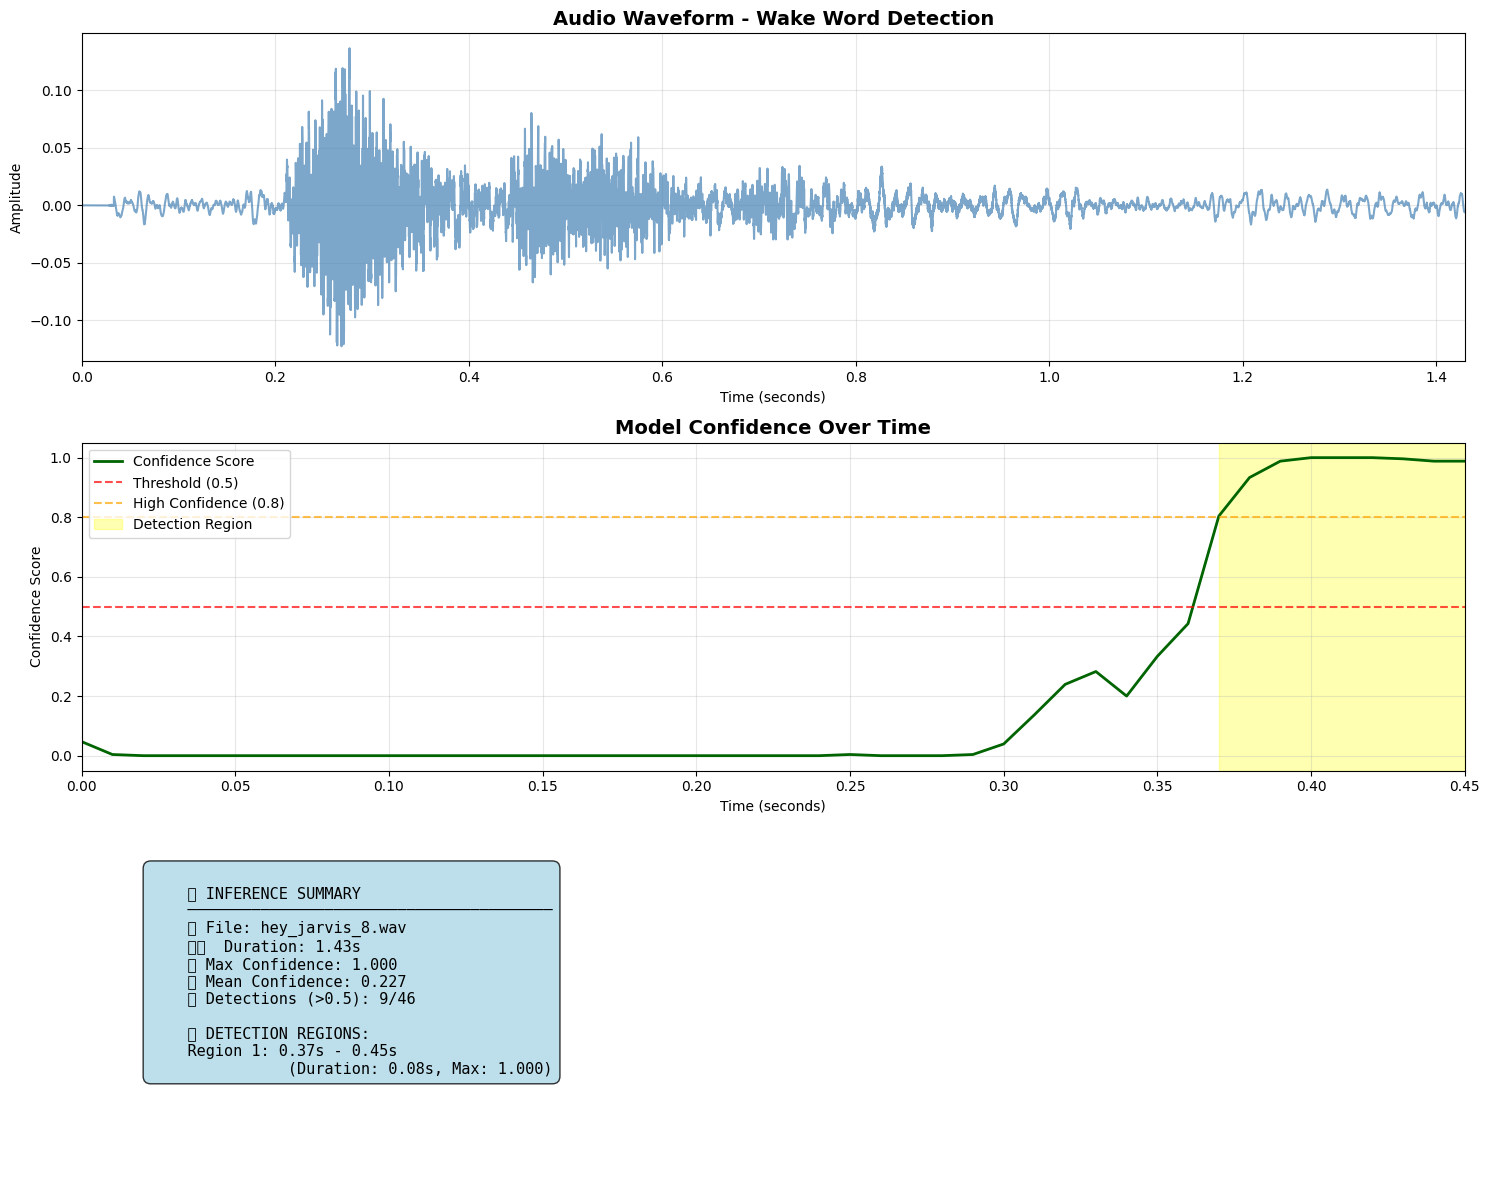


🏁 Completed testing 1 files successfully!


In [20]:
import numpy as np
import torchaudio
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from microwakeword.inference import Model as InferenceModel
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Initialize the inference model
print("🚀 Initializing microWakeWord Inference Model...")
model_path = "trained_models/wakeword/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite"

try:
    inference_model = InferenceModel(tflite_model_path=model_path)
    print(f"✅ Model loaded successfully from: {model_path}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

def load_audio_file(file_path, target_sr=16000):
    """
    Load and preprocess audio file for inference.
    
    Args:
        file_path (str): Path to audio file
        target_sr (int): Target sample rate (default: 16000)
    
    Returns:
        tuple: (audio_data, sample_rate, duration)
    """
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resample if necessary
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
            waveform = resampler(waveform)
            sample_rate = target_sr
        
        audio_data = waveform.squeeze().numpy()
        duration = len(audio_data) / sample_rate
        
        return audio_data, sample_rate, duration
    
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None, None, None

def analyze_confidence_scores(scores, threshold=0.5, step_ms=10):
    """
    Analyze confidence scores and extract detection metrics.
    
    Args:
        scores (list): Confidence scores from model inference
        threshold (float): Detection threshold
        step_ms (int): Time step in milliseconds
    
    Returns:
        dict: Analysis results
    """
    scores = np.array(scores)
    time_axis = np.arange(len(scores)) * step_ms / 1000.0  # Convert to seconds
    
    # Find detections above threshold
    detections = scores >= threshold
    detection_indices = np.where(detections)[0]
    
    # Calculate metrics
    max_confidence = np.max(scores)
    mean_confidence = np.mean(scores)
    detection_count = np.sum(detections)
    
    # Find activation regions (consecutive detections)
    activation_regions = []
    if len(detection_indices) > 0:
        regions = []
        current_start = detection_indices[0]
        current_end = detection_indices[0]
        
        for i in range(1, len(detection_indices)):
            if detection_indices[i] == detection_indices[i-1] + 1:
                current_end = detection_indices[i]
            else:
                regions.append((current_start, current_end))
                current_start = detection_indices[i]
                current_end = detection_indices[i]
        regions.append((current_start, current_end))
        
        for start_idx, end_idx in regions:
            start_time = time_axis[start_idx]
            end_time = time_axis[end_idx]
            max_conf_in_region = np.max(scores[start_idx:end_idx+1])
            activation_regions.append({
                'start_time': start_time,
                'end_time': end_time,
                'duration': end_time - start_time,
                'max_confidence': max_conf_in_region
            })
    
    return {
        'max_confidence': max_confidence,
        'mean_confidence': mean_confidence,
        'detection_count': detection_count,
        'total_samples': len(scores),
        'activation_regions': activation_regions,
        'time_axis': time_axis,
        'scores': scores
    }

def plot_inference_results(audio_data, analysis_results, sample_rate, title="", audio_path=""):
    """
    Create comprehensive visualization of inference results.
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Audio waveform
    time_audio = np.arange(len(audio_data)) / sample_rate
    axes[0].plot(time_audio, audio_data, color='steelblue', alpha=0.7)
    axes[0].set_title(f'Audio Waveform - {title}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, max(time_audio))
    
    # Plot 2: Confidence scores
    time_axis = analysis_results['time_axis']
    scores = analysis_results['scores']
    
    axes[1].plot(time_axis, scores, color='darkgreen', linewidth=2, label='Confidence Score')
    axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold (0.5)')
    axes[1].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='High Confidence (0.8)')
    
    # Highlight activation regions
    for region in analysis_results['activation_regions']:
        axes[1].axvspan(region['start_time'], region['end_time'], 
                       alpha=0.3, color='yellow', label='Detection Region' if region == analysis_results['activation_regions'][0] else "")
    
    axes[1].set_title('Model Confidence Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Confidence Score')
    axes[1].set_ylim(-0.05, 1.05)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_xlim(0, max(time_axis) if len(time_axis) > 0 else 1)
    
    # Plot 3: Detection summary
    axes[2].axis('off')
    
    # Create summary text
    summary_text = f"""
    📊 INFERENCE SUMMARY
    ────────────────────────────────────────
    📁 File: {os.path.basename(audio_path)}
    ⏱️  Duration: {len(audio_data)/sample_rate:.2f}s
    🎯 Max Confidence: {analysis_results['max_confidence']:.3f}
    📈 Mean Confidence: {analysis_results['mean_confidence']:.3f}
    🔔 Detections (>0.5): {analysis_results['detection_count']}/{analysis_results['total_samples']}
    
    🎯 DETECTION REGIONS:"""
    
    if analysis_results['activation_regions']:
        for i, region in enumerate(analysis_results['activation_regions'], 1):
            summary_text += f"""
    Region {i}: {region['start_time']:.2f}s - {region['end_time']:.2f}s 
               (Duration: {region['duration']:.2f}s, Max: {region['max_confidence']:.3f})"""
    else:
        summary_text += "\n    ❌ No detections above threshold"
    
    axes[2].text(0.05, 0.95, summary_text, transform=axes[2].transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig

def test_single_audio_file(file_path, show_plots=True, threshold=0.5):
    """
    Test inference on a single audio file with comprehensive analysis.
    
    Args:
        file_path (str): Path to audio file
        show_plots (bool): Whether to display visualization
        threshold (float): Detection confidence threshold
    
    Returns:
        dict: Complete inference results
    """
    print(f"\n🎵 Testing: {file_path}")
    print("─" * 60)
    
    # Load audio
    audio_data, sample_rate, duration = load_audio_file(file_path)
    if audio_data is None:
        return None
    
    # Run inference
    try:
        start_time = datetime.now()
        confidence_scores = inference_model.predict_clip(data=audio_data)
        inference_time = (datetime.now() - start_time).total_seconds()
        
        print(f"✅ Inference completed in {inference_time:.3f}s")
        
    except Exception as e:
        print(f"❌ Inference failed: {e}")
        return None
    
    # Analyze results
    analysis = analyze_confidence_scores(confidence_scores, threshold)
    
    # Create result dictionary
    results = {
        'file_path': file_path,
        'audio_data': audio_data,
        'sample_rate': sample_rate,
        'duration': duration,
        'confidence_scores': confidence_scores,
        'analysis': analysis,
        'inference_time': inference_time
    }
    
    # Display results
    if show_plots:
        plot_inference_results(audio_data, analysis, sample_rate, 
                             title=f"Wake Word Detection", audio_path=file_path)
    
    # Play audio
    display(Audio(file_path))
    
    return results

# Test with the recorded sample
print("🎯 SINGLE FILE INFERENCE TEST")
print("=" * 70)

test_files = [
    "recorded_samples/hey_jarvis_8.wav",
]

# Check if files exist and test them
results_list = []
for audio_file in test_files:
    if os.path.exists(audio_file):
        result = test_single_audio_file(audio_file, show_plots=True, threshold=0.5)
        if result:
            results_list.append(result)
    else:
        print(f"⚠️  File not found: {audio_file}")

print(f"\n🏁 Completed testing {len(results_list)} files successfully!")